In [11]:
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.stats import chisquare
import pandas as pd
import pyrr
from tqdm import tqdm

# basedir = os.path.dirname(os.getcwd())
basedir = os.path.abspath(os.path.join(os.getcwd() ,"../"))
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')
_images = os.path.join(basedir, 'images')

sys.path.insert(1, _py)
import loads
import lia
import ray as rayt
import lad
import figures

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%matplotlib qt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Towards kiwifruit canopy reconstruction with LiDAR technology
## Testing Pipeline with simulated LiDAR

By: Dr. Omar Ruiz-Macias

with Dr. Alvaro Orsi

```{image} ../images/planttech_logo.png
:align: center
```


```{image} ../images/planttech_logo.png
:alt: fishy
:class: bg-primary mb-1
:width: 200px
:align: center
```

```{figure} ../images/planttech_logo.png
---
scale: 50%
align: right
---
Here is my figure caption!
```

# Outline

The following include the process to extract the `Leaaf Area Density` (LAD) from a mock point cloud generated in `Blensor` software. This process is splitted in 3 main cores:

- **LiDAR simulation on mockup trees with BLENSOR**
- **Data structure**
- **Leaf Inclination Angle (LIA) estimation**
- **Leaf Area Density (LAD) estimation**
- **Aplication on Kiwkifruit LiDAR dataset**


# Preparation of data

In order to get the LIA and hence the LAD, we need to segmentated the trees and the leaves.

First, we define the name of the directory where the Blensor output data is, in this particular case we will look for directory `test`. Pipeline will look for this directory inside the `data` directory.

In [2]:
mockname = 'test'

Next, we convert Blensor output txt files that have fake numpy extension to real npy.

In [3]:
loads.numpy2npy(mockname)

s0500000.numpy done --> Number of beams: 22500
s0200000.numpy done --> Number of beams: 22500
s0700000.numpy done --> Number of beams: 22500
s0400000.numpy done --> Number of beams: 22500
s0100000.numpy done --> Number of beams: 22500
s0600000.numpy done --> Number of beams: 22500
s0300000.numpy done --> Number of beams: 22500


Now we create the module to segmentate trees. This will be tuned acordingly for each data set, so below module only works for this particular data set.

In [4]:
def segtree(df, show=False):

    trees = {}

    if show:
        plt.figure(figsize=(14, 8))

    # centres
    x, y = [0], [0]
    num = 0
    dx, dy = 5, 5

    for i in x:
        for j in y:
            
            keep = np.ones(len(df['x']), dtype=bool)
            keep &= (df['x'] < i+dx) & (df['x'] > i-dx)
            keep &= (df['y'] < j+dy) & (df['y'] > j-dy)

            trees['tree_%s' %(str(num))] = keep
            
            if show:
                plt.scatter(df['x'][leaves & keep], df['y'][leaves & keep], s=0.5, label=num)
                        
            num += 1

    if show:
        plt.legend()
    
    return trees


That's it! Now we can segmentate trees. First, with function `npy2pandas` we load all the `npy` files into a pandas DataFrame (DF). Then, since this is a mockup dataset, we can easily separate the leaves from everythin else in the point cloud (PC). We do this with function `extract_leaves` that requires the pandas DF as input. Finally, we invoke the above module to segmentate trees that requires the pandas DF as well.

outputs from this are:

* `df`: Pandas DF with the entire PC
* `leaves`: Boolean array of PC dimensions with True for Points concerning leaves only
* `trees`: python dictionary where each entry contains one tree in the form of boolena array with PC dimensions


In [5]:
# load data into a pandas data frame
df = loads.npy2pandas(mockname)
# extract leaves. Boolean array output
leaves = loads.extract_leaves(df, show=False)
# extract trees. Dictionary with boolean arrays output
trees = segtree(df)

Below piece of code shows an example of how to visualize the leaves points from one tree only.

In [6]:
# show the point cloud from leaves of firs tree only
keep = (trees['tree_0']) & (leaves)
loads.showPCfromDF(df[keep])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Compute the `Leaf Inclination Angle` (LIA) for each tree

The function that computes the LIA `leaf_angle` uses a KDtree approximation and the steps are as follow: 

a) `Compute normals`: This method fits a plane based on the nearesth neighbors for each point and gets the normal of this plane.
    
b) `Compute zenith angles`: Then, using the dot product with get the angle with respect to the zenith (i.e. agains vector (0, 0, 1)) 
    
c) `Range correction`: The results angles run from $0 < \theta < 180$, however we require these to be in the range $0 < \theta < 90$ therefore we transfom those angles $> 90$ with relation:

$$\theta_{L} = 180 - \theta$$

d) `Weights correction`: The resulting LIA is biased to PC density and completeness. In order to reduce this biases, we compute weights via voxelization,

$$\eta_{i} = n_{i}/L^{3} \\
  \bar{\eta} = \frac{1}{N}\sum_{i=0}^{N} \eta{i}$$

where $n_{i}$ is the number of points within voxel $i$, $L$ is the voxel size, and $N$ is the total number of voxels, then $\eta_{i}$ is the volume density of voxel $i$, and $\bar{\eta}$ is the mean volume density.




The function `leaf_angle` has to be ran per tree and requieres 6 input parameters:

* `points`: $x$, $y$ and $z$ coordinates of the leaf point cloud (LPC).
* `mockname`: name of directory where the data is.
* `treename`: name/index of tree.
* `voxel_size_w`: voxel size for `weights correction` i.e. $L$.
* `kd3_sr`: KDtree searching radius for the nearest neighboors serch.
* `max_nn`: Maximum number of nearest neightbors to be considered.

This function returns a set of files inside directory `lia`:

* `angles_<treename>.npy`: LIA for the LPC. One file per tree.
* `weights_<treename>.npy`: LIA weights for the LPC. One file per tree.
* `leaf_angle_dist_<treename>.png`: Figure of LIA ($\theta_{L}$) distribution with `weights correction`. If `Truth` LIA available, this will be shown alongside. One figure per tree.
* `leaf_angle_dist_height_<treename>.png`: Top - Figure of LPC distribution accross different heights in terms of voxels $k$. Bottom - If `Truth` LIA available, $\theta_{L}^{truth} - \theta_{L}$. The different curves show this for different heights ($k$). One figure per tree.

If truth LIA available i.e. there's a mesh file `mesh.ply` in the root direcory, then we will be able to run function `bestfit_pars_la` which essentialy runs `leaf_angle` for a range of values in `voxel_size_w`, `kd3_sr` and `max_nn` and find the best-fit for these three based on the minimal $\chi^{2}$ between the estimated LIA and the truth LIA.

`bestfit_pars_la` is as well ran per tree and requires only `points`, `mockname` and `treename`. It returns `bestfit_<treename>.npy` file that contains the `voxel_size_w`, `kd3_sr` and `max_nn` best-fit values per tree. it also returns a dictionary with the $\chi^{2}$ for each of these runs.

Using output dictionary from `bestfit_pars_la` we can run `bestfit_pars_la` to create figure `bestfits_pars_treename>.png` that shows the $\chi^{2}$ for all the ranges used in `voxel_size_w`, `kd3_sr` and `max_nn`.

## TO-DO:

Current LIA implementation can work without `Truth` LIA, however, we need the `Truth` to estimate the optimal `voxel_size_w`, `kd3_sr` and `max_nn` parameters. We need to find the relation between these three and LPC that could rely on the LPC density, leaf size, leaf area, etc.


The piece of code bellow runs `bestfit_pars_la` and `best_fit_pars_plot` for each tree.

voxel_size_w 0.0001 DONE...
voxel_size_w 0.001 DONE...
voxel_size_w 0.01 DONE...
voxel_size_w 0.1 DONE...
voxel_size_w 1 DONE...
voxel_size_w BESTFIT:	 0.01
kd3_sr 0.001 DONE...
kd3_sr 0.01 DONE...
kd3_sr 0.1 DONE...
kd3_sr 1.0 DONE...
kd3_sr BESTFIT:	 1.0
max_nn 3 DONE...
max_nn 5 DONE...
max_nn 10 DONE...
max_nn 20 DONE...
max_nn 50 DONE...
max_nn 100 DONE...
max_nn BESTFIT:	 5


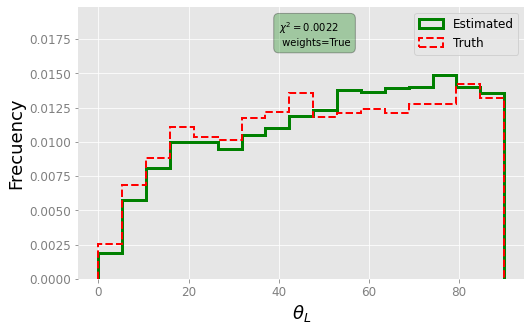

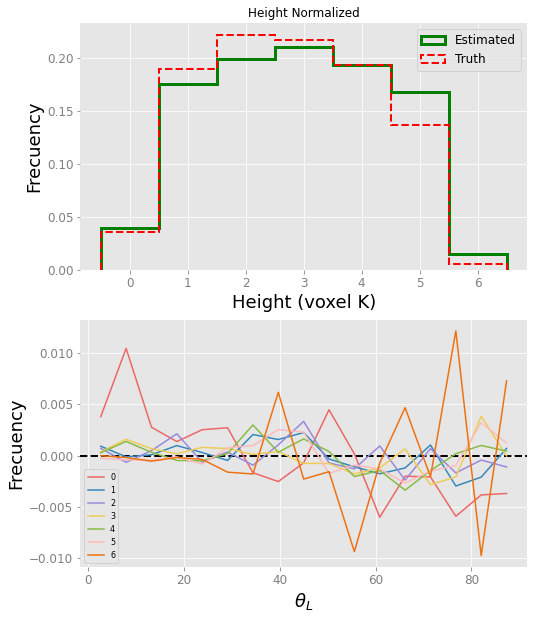

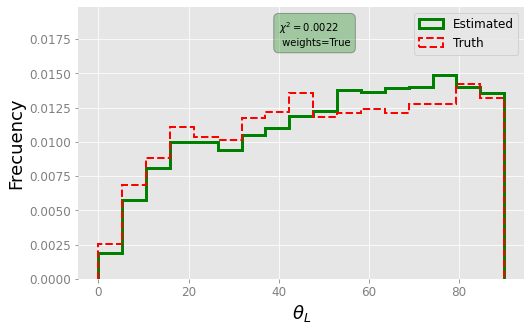

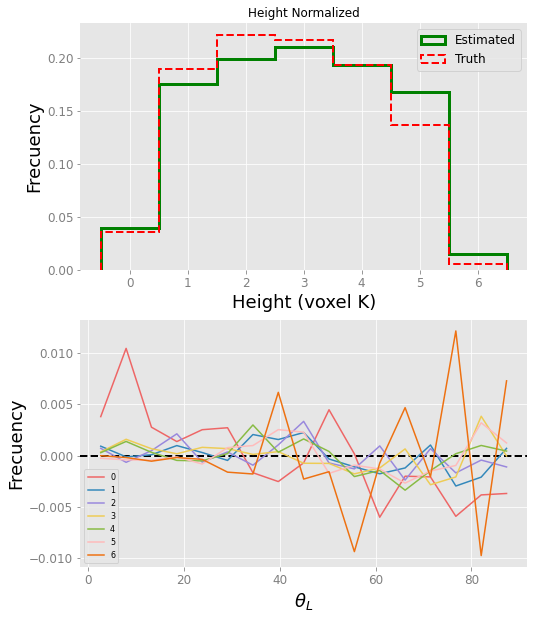

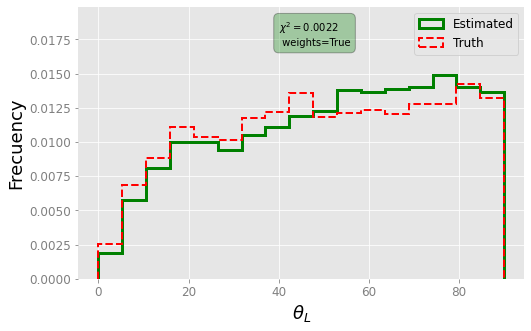

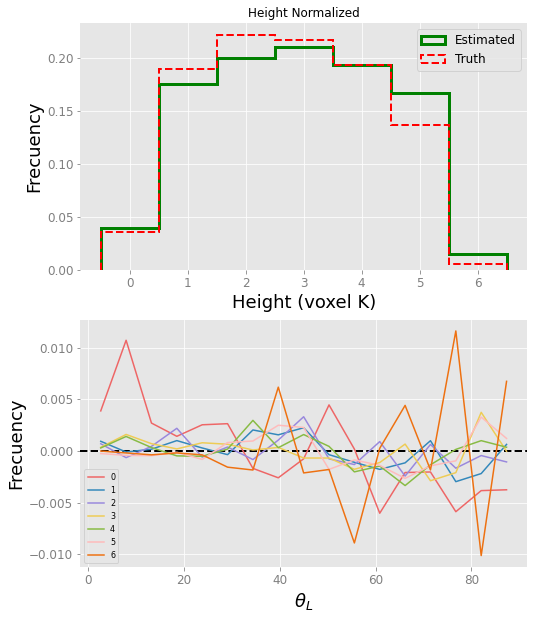

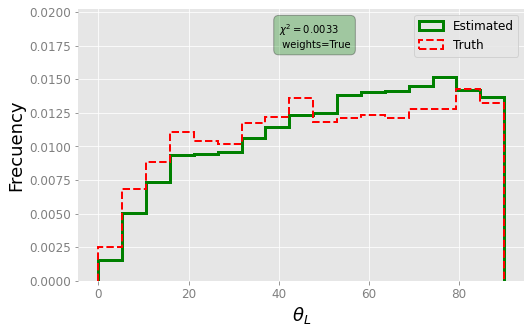

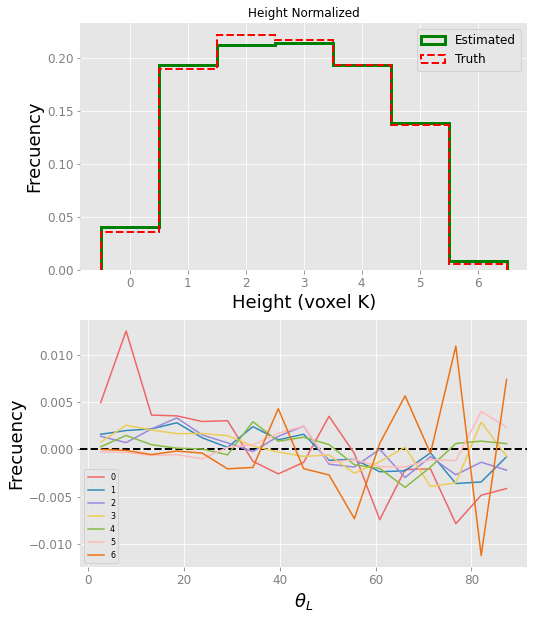

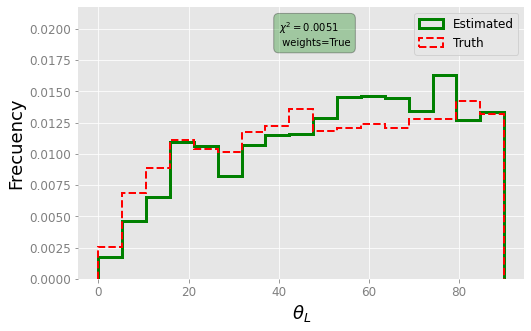

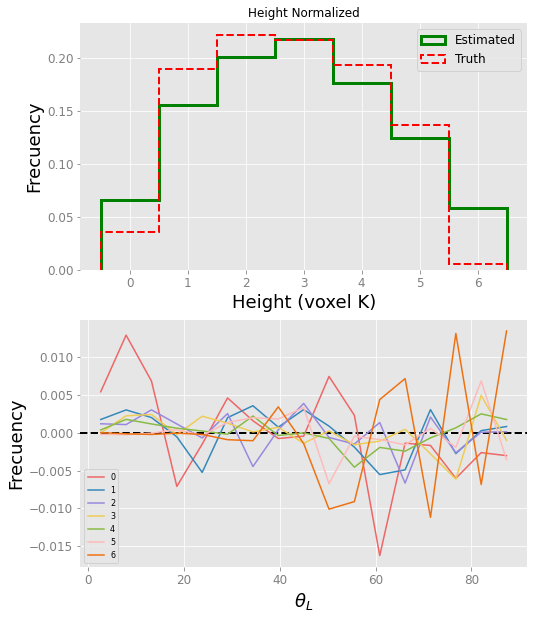

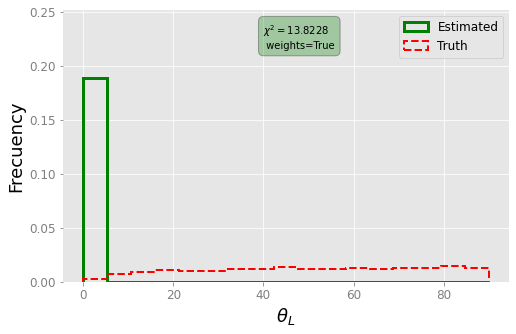

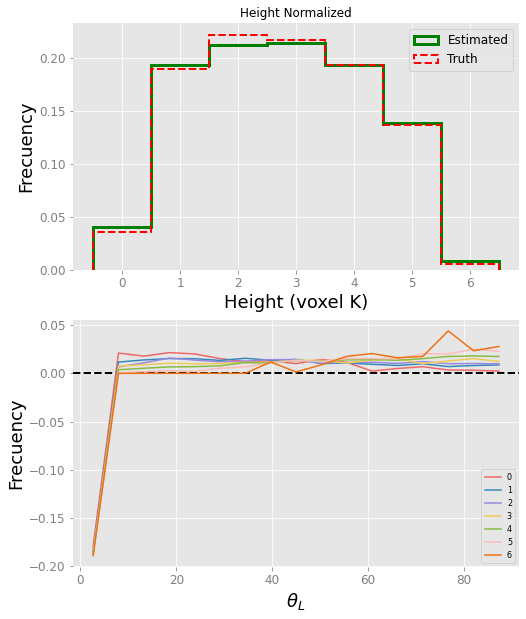

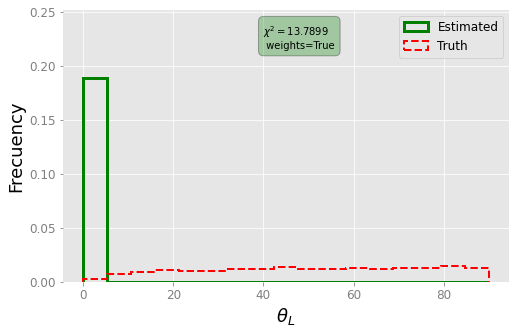

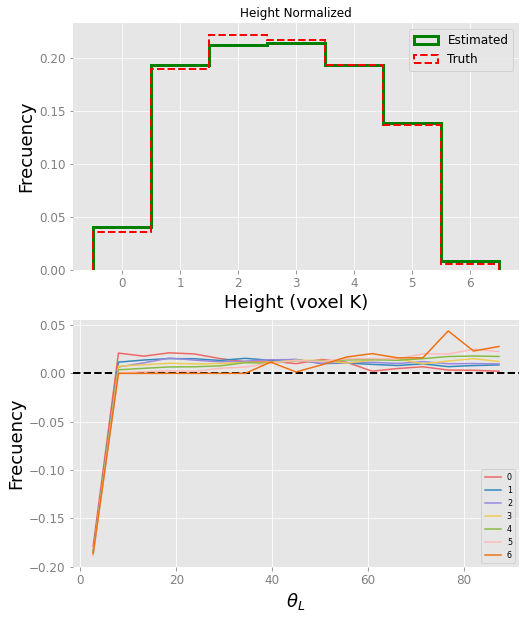

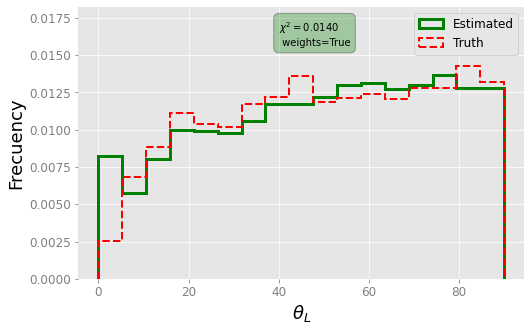

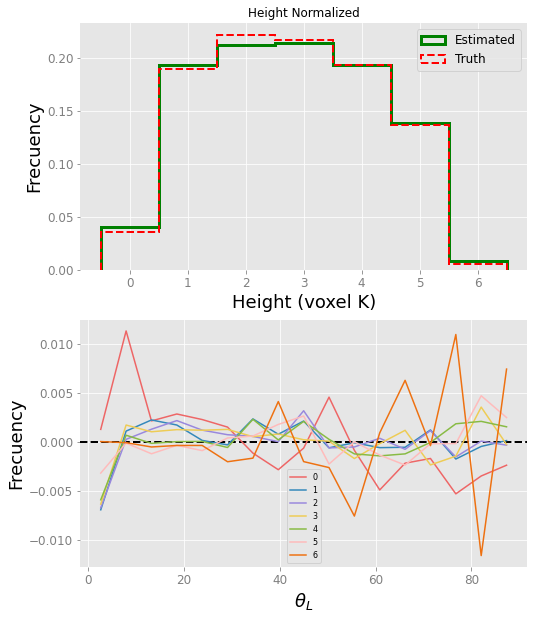

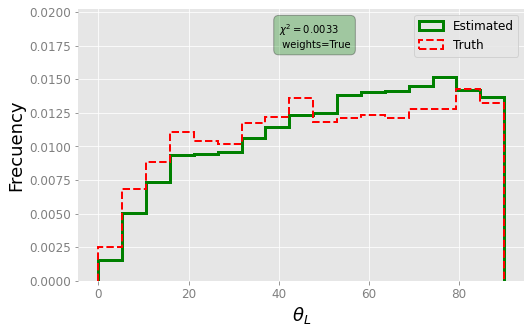

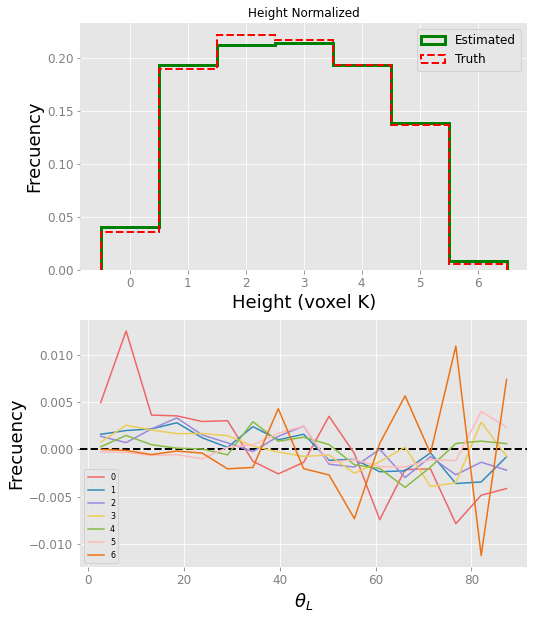

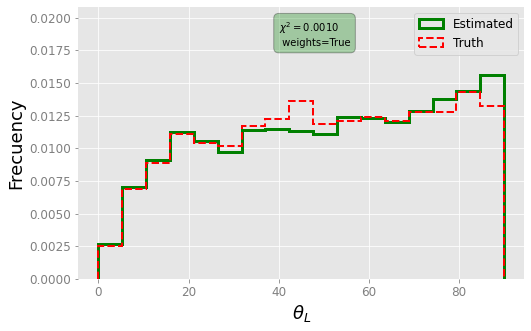

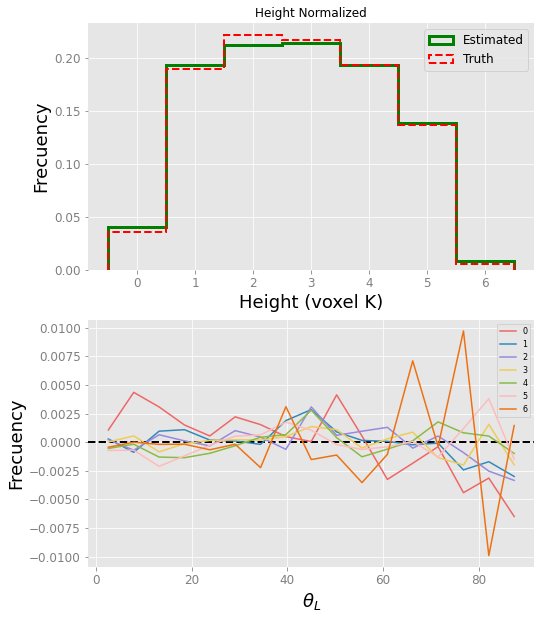

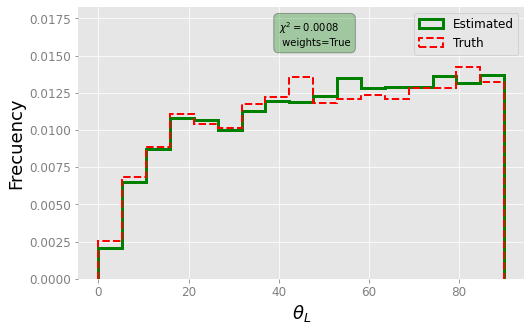

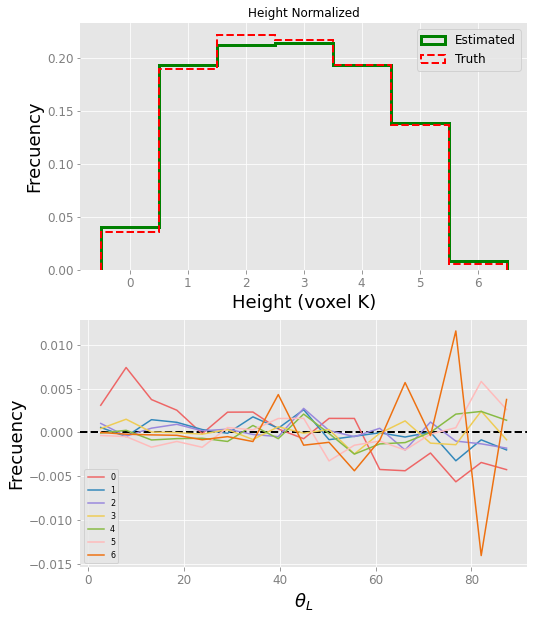

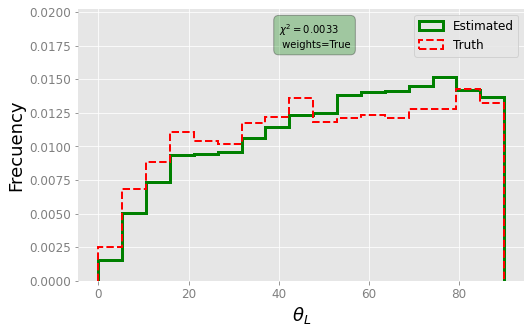

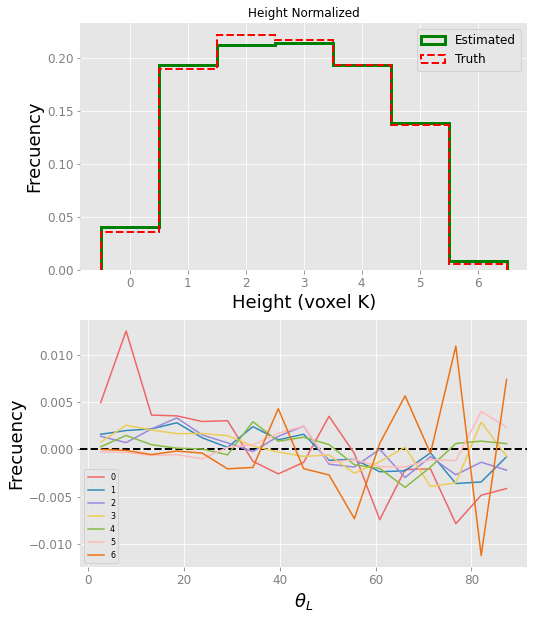

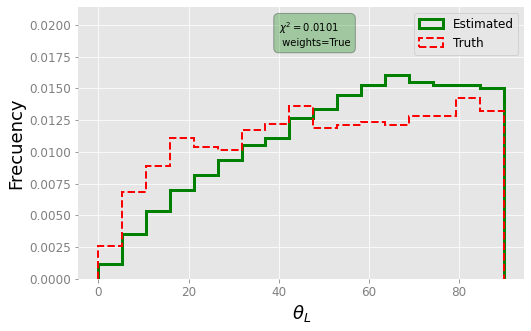

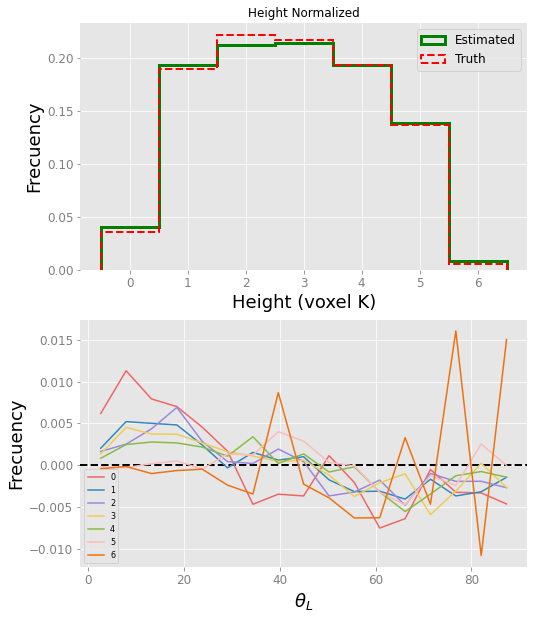

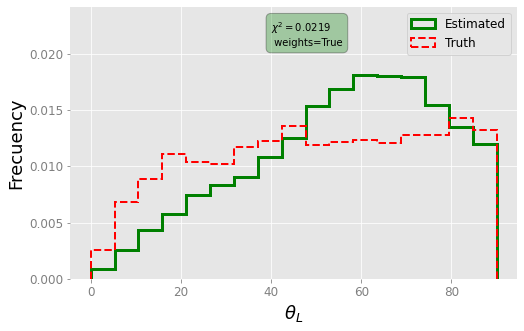

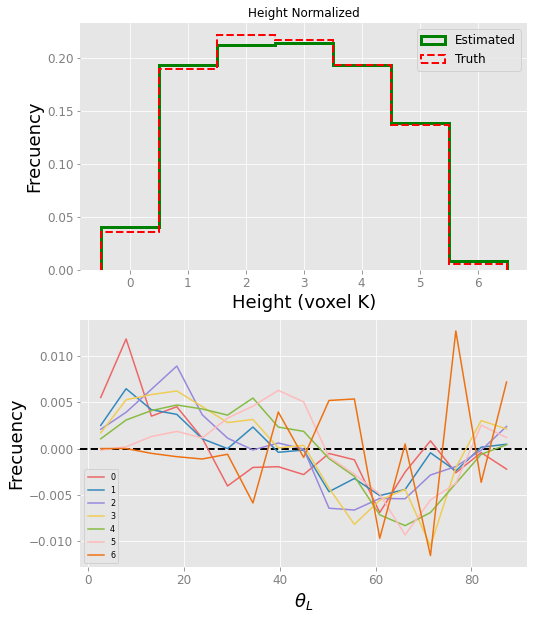

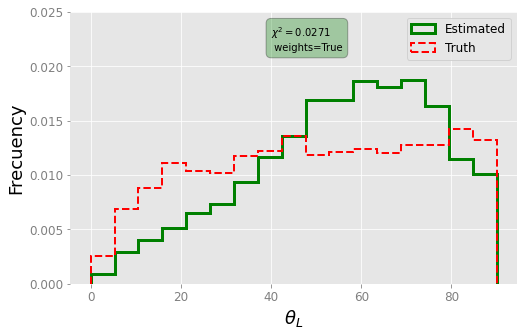

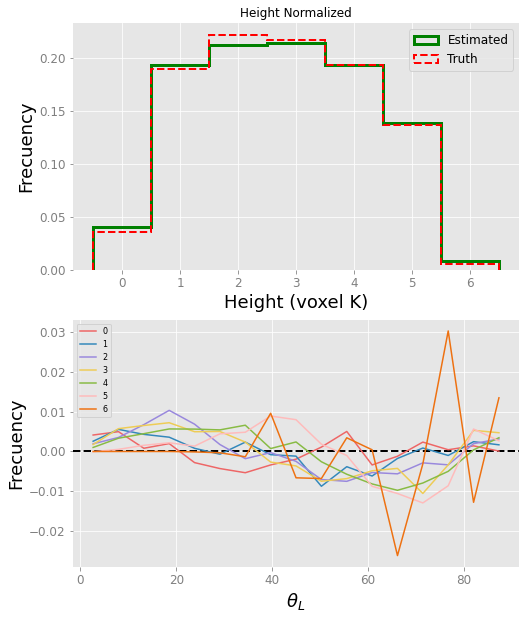

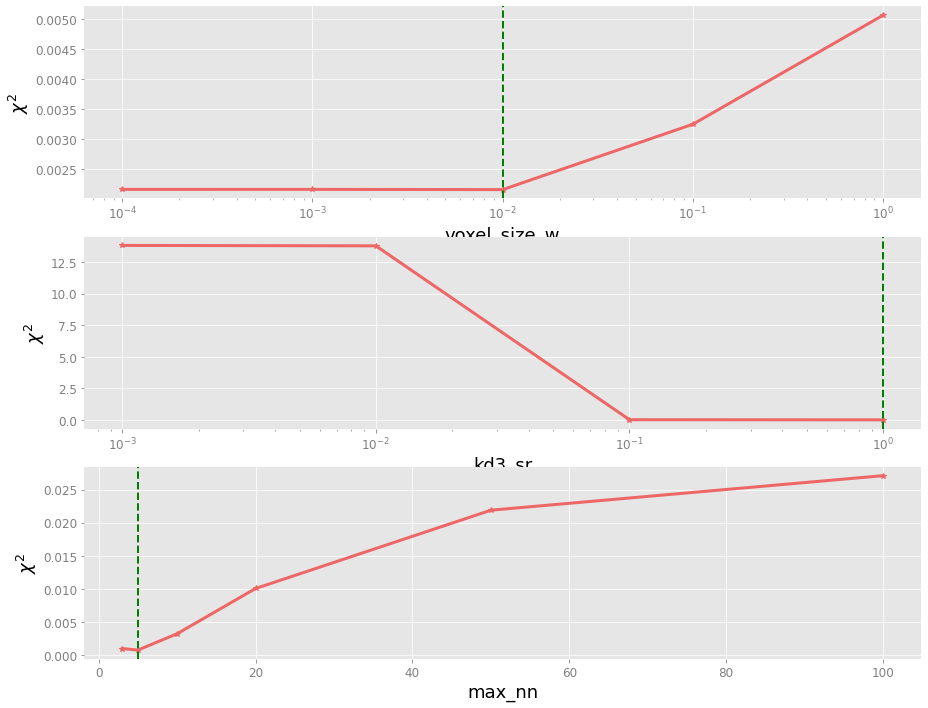

In [7]:
for key, val in trees.items():

    keep = (val) & (leaves)
    df_ = df[['x', 'y', 'z']][keep]
    points = loads.DF2array(df_)
    res = lia.bestfit_pars_la(points, mockname, treename=key)
    lia.best_fit_pars_plot(res, key, mockname)


once we find the best-fit parameters we use them and run `leaf_angle` and get the LIA and corresponding weigths per tree. This is shown bellow.

leaf area=0.04 
 voxel_size_w=0.0100 
 kd3_sr=1.0000 
 max_nn=5.0000 


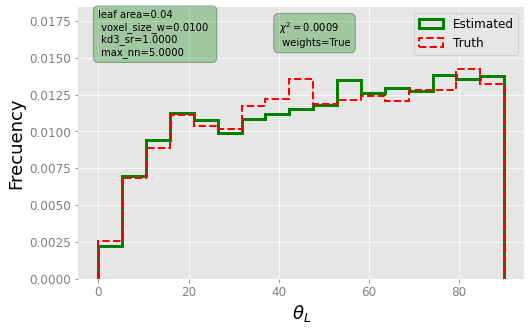

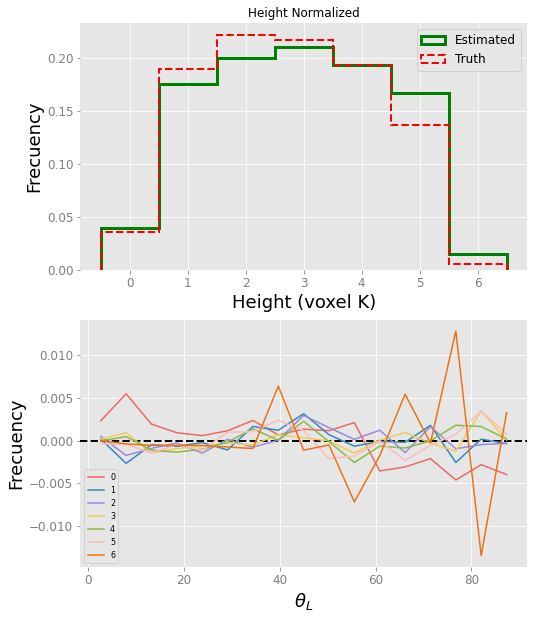

In [8]:
# load bestfit results
for key, val in trees.items():

    keep = (val) & (leaves)
    df_ = df[['x', 'y', 'z']][keep]
    points = loads.DF2array(df_)

    bestfit_file = os.path.join(_data, mockname, 'lia', 'bestfit_%s.npy' %(key))
    res = np.load(bestfit_file, allow_pickle=True)
    res = res.tolist()

    text = 'leaf area=%.2f \n %s=%.4f \n %s=%.4f \n %s=%.4f ' %(res['leafsize'], 'voxel_size_w', res['voxel_size_w_bestfit'],'kd3_sr', res['kd3_sr_bestfit'],'max_nn', res['max_nn_bestfit'])
    print(text)

    chi2 = lia.leaf_angle(points, mockname, key, res['voxel_size_w_bestfit'], 
                            res['kd3_sr_bestfit'], res['max_nn_bestfit'], save=True,
                                savefig=True, text=text)
                                

# `Leaf Area Density` (LAD)

The LAD method implemented here uses the `Voxel 3D contact-bases frecuency` method first introduced by `HOSOI AND OMASA: VOXEL-BASED 3-D MODELING OF INDIVIDUAL TREES FOR ESTIMATING LAD`.

The model looks like:

$$LAD(h, \Delta H) = \frac{1}{\Delta H} \sum_{k=m_{h}}^{m_{h}+\Delta H} l(k),$$

where,

$$l(k) = \alpha(\theta)N(k) \\
    = \alpha(\theta) \cdot \frac{n_{I}(k)}{n_{I}(k) + n_{P}(k)}.$$

$l(k)$ is the `Leaf Area Index` (LAI) of the kth horizontal layer of the voxel array within a plant region, $\Delta H$ is the horizontal layer thickness, and $m_{h}$ and $m_{h}+\Delta H$ are the voxel coordinates on the vertical axis equivalent to height $h$ and $h+\Delta H$ in orthogonal coordinates ($h = \Delta k \times m_{h}$). The LAI of the kth horizontal layer $l(k)$ is the product of the contact frequency $N(k)$ of laser beams in the k$th layer and the coefficient $\alpha(\theta)$, which corrects for leaf inclination at laser incident zenith angle $\theta$.

$n_{I}(k)$ is the number of voxels where the laser beams is intercepted by the kth layer, $n_{P}(k)$ is the number of voxels where the laser beams passed through the kth layer, and $n_{I}(k) + n_{P}(k)$ is the total number of voxels where the incident laser beams reach the kth layer.

Despite the complexity of this method, it requieres only one parameter, the `voxel_size`. We will introduce a second parameter, the `downsample` whose importance will be explained later. The main steps towards LAD estimation are:

1) Computing $n_{P}(k)$
2) Computing $n_{I}(k)$
3) Computing $\alpha(\theta)$
4) Estimate LAD


For this example, we will usea a `voxel_size` = 0.2 and `downsample` = 0.05 which means that we downsample our whole data to only $5\%$. A reminder that as well as in for the LIA, the following process is per tree.

In [23]:
downsample = 0.05
voxel_size = 1
# to check everything looks fine
show = False
sample = None

## Computing $n_{P}(k)$

Seeing where the beam pass through in the voxelize `Plant Region` (PR) is a tipycal ray tracing problem and it's reduced to see whether the ray hit or not an axis align bounding box (AABB).

The below module grabs the requiered downsample percentge of the data randomly and if it's the first time we ran this, it will create the directory `lad_<downsmple>`. All the subsequent results will be stored inside this directory. The first time a particular downsample is ran, it will store the file `inds.npy` containing a boolean array with size of the pandas DF. If we change the `voxel_size` but not the `downsample`, then the below module will look first for the `inds.npy` instead of searching for another random subsample, this to maintain uniformity between different voxels sizes approaches.

The function `main` does the magic here, it has to be ran per tree and requires 6 input parameters:

* `points`: $x$, $y$ and $z$ coordinates from the downsample data in the form of numpy array.
* `sensors`: $x$, $y$ and $z$ coordinates of sensor responsible from each point in `points` parameter above.
* `pointsPR`: `points` above filtered to the LPC.
* `voxel_size`: Voxel Size.
* `resdir`: Name of output directory for the specific `downsample`.
* `treename`: Name/index of tree.

NOTE: `pointsPR` is required to get the same voxelization dimensions as in $n_{I}$.

This function returns two files:

* `m3s_<treename>_<voxel_size>.npy`: numpy boolean 3D-array with number of voxels dimensions. True if a beam hit the voxel.
* `m3count_<treename>_<voxel_size>.npy`: numpy 3D-array with number of voxels dimensions. Each entry contains the number of beams that passed trhough that voxel.

### To-Do

Note that this is the slowest module of the entire pipeline, taking up to 5 minutes  for sample of 10,000 beams. This can be improved easlily if binding with a C++ ray AABB module instead.

In [24]:

POINTS = loads.DF2array(df[['x', 'y', 'z']])
SENSORS = loads.DF2array(df[['sx', 'sy', 'sz']])

if downsample is not None:

    resdir = os.path.join(_data, mockname, 'lad_%s' %(str(downsample)))
    if not os.path.exists(resdir):
        os.makedirs(resdir)

    outdir = os.path.join(resdir, 'inds.npy')
    if os.path.exists(outdir):
        print('inds file already exists for donwnsample of %.3f at %s' %(downsample, outdir))

        inds = np.load(outdir)

        points = POINTS[inds]
        sensors = SENSORS[inds]

    else:

        print('inds not been created yet for donwnsample of %.3f' %(downsample))
        idx = np.random.randint(0, len(df), int(len(df) * downsample))
        inds = np.zeros(len(df), dtype=bool)
        inds[idx] = True

        points = POINTS[inds]
        sensors = SENSORS[inds]

        np.save(outdir, inds)

else:

    resdir = os.path.join(_data, mockname, 'lad')
    if not os.path.exists(resdir):
        os.makedirs(resdir)

if sample is not None:

    idx = np.random.randint(0, len(df), int(sample))
    points = POINTS[idx]
    sensors = SENSORS[idx]

for key, val in trees.items():

    inPR = (val) & (leaves) & (inds)
    pointsPR = POINTS[inPR]
    m3s, m3count= rayt.main(points, sensors, pointsPR, voxel_size, resdir, key, show=show)
    

inds file already exists for donwnsample of 0.050 at /Users/omar/projects/planttech/data/test/lad_0.05/inds.npy
max --> [9, 9, 6]
min --> [0, 0, 0]


2it [00:00, 126.33it/s]

tot vox: 	 700
voxels hitted: 	 7
Percentage of voxels hitted by beam: 0.01


## Computing $n_{I}(k)$

The $n_{I}$ per voxel is computed in function `compute_attributes`. It essentialy voxelize the LPC to get the PR dimensions (which have to be the same as in $n_{P}$). Then, for a numpy boolean 3D-array with voxelize PR dimensions, we fill it with True if there's a point in the voxel.

This function looks for previous `m3s_<treename>_<voxel_size>.npy` result and get the attributes in the form of the same size numpy 3D-array (`m3att`). The attributes are:

* 1 if any LPC in that voxel
* 2 if any beam pass trhough that  voxel
* 3 if none of previous

It requires 4 input parameters `pointsPR`, `resdir`, `voxel_size`, `treename` which were defined in section `Computing $n_{P}(k)$`. It returns the attributes numpy 3D-array.

## Computing $\alpha(\theta)$

$\alpha(\theta)$ is expressed in terms of $G(\theta)$, 

$$\alpha(\theta) = \frac{\cos(\theta)}{G(\theta)},$$

where $G(\theta)$ is the mean projection of a unit leaf area on a plane perpendicular to the direction of the laser beam. This quantity is determined with the assumption that leaves are positioned symmetrically with respect to the azimuth anc can be represented as:

$$G(\theta) =  \sum_{q=1}^{T_{q}} g(q) S(\theta, \theta_{L}(q))$$

where $S(\theta, \theta_{L}(q))$ is expresed in terms of the leaf in-inclination angle $\theta_{L}$ (the zenith angle of the normal to the leaf surface), and $\theta$ is the laser-beam incident zenith angle:

$$S(\theta, \theta_{L}) = \cos\theta \cos \theta_{L}, \hspace{.5cm} \textrm{for } \theta \leq \pi/2 - \theta_{L}$$
$$S(\theta, \theta_{L}) = \cos\theta \cos \theta_{L} \left[ 1 + \frac{2}{\pi}(\tan x - x) \right], \hspace{.5cm} \textrm{for } \theta \gt \pi/2 - \theta_{L}$$

$$x = \cos^{-1}\left( \cot \theta \cot \theta_{L} \right).$$

Here $q$ is the leaf-inclination-angle class and Tq is the total number of leaf-inclination-angle classes. Thus, if there are $18$ leaf-inclination-angle classes from $0◦$ to $90◦$ ($Tq = 18$), then each class consists of a $5◦$ interval. For example, $q = 1$, $q = 9$, and $q = 16$ include the angles from $0◦$ to $4◦$, $40◦$ to $44◦$, and $75◦$ to $79◦$, respectively. $g(q)$ is the distribution of the leaf-inclination-angle class $q$, which is a ratio of the leaf area belonging to class $q$ to total leaf area; $θ_{L}(q)$ is the midpoint angle of class $q$, which is the leaf-inclination angle used to represent class $q$.

This process is done trhough function `Gtheta`. In function `alpha_k` we compute $\alpha(\theta)$ for the median of $\theta$ the Beam Inclination Angles (BIA) with respect to zenith in the Kth layer. We made use of the files `angles_<treename>.npy` and `weights_<treename>.npy` we store previously in the directory `lia` to get $g(q)$. The function `alpha_k` create three figures inside the `figures` directory:

* `alphas_<treename>_<voxel_size>.png`: $\alpha(\theta)$ for $0 < \theta < 90$. The black-dashed line is $\alpha(\theta)$ with $G(\theta)$ using all the weighted LIAs, while the coloured-solid lines are with $G(\theta)$ using the weighted LIAs only in the Kth layer. The yellow shadow shows the BIAs range, and the vertical red-dashed line shows the "magic" angle at $\theta = 57.5$ where $\alpha(\theta)$ is close to a constant value of $1.1$.
* `bia_<treename>_<voxel_size>.png`: The BIAs distribution pre and after angle range correction.
* `bia_per_k_<treename>_<voxel_size>.png`: The BIAs distribution in the Kth layer.

## Estimate LAD

Now that we have $\alpha(\theta, K)$ in the Kth layer, we can compute the LAI and therefore, the LAD. We do this in function `get_LADS` which requires 4 input parameters:

* `m3att`: The numpy 3D-array attributes.
* `voxel_size`: Voxel Size.
* `kbins`: $\Delta H$ in lengths if K.
* `alphas_k`: `alpha_k` function output.

This returns a numpy 2D-array with the height and LAD for the corresponding height with zero being the bottom of the PR.

Finally, with function `plot_lads` we plot LAD as a function of height for:

1) Using correction of $\alpha(\theta, K)$ for the median of $\theta$ in the Kth layer.
2) Without $\alpha(\theta, K)$ correction
3) Truth LAD from mesh file.

This figure is saved in directory `figures` with name `LAD_<treename>_<voxel_size>.png`.

In [12]:
downsample = 0.05
voxel_size = 0.2

In [13]:
if downsample is not None:
    inds_file = os.path.join(resdir, 'inds.npy')
    inds = np.load(inds_file)
    resdir = os.path.join(_data, mockname, 'lad_%s' %(str(downsample)))
    print('downsample:', downsample)
else:
    inds = np.ones(len(df), dtype=bool)
    resdir = os.path.join(_data, mockname, 'lad')

isfigures = os.path.join(resdir, 'figures')
if not os.path.exists(isfigures):
    os.makedirs(isfigures)

print('voxel_size:', voxel_size)

for key, val in trees.items():

    inPR = (val) & (leaves) & (inds)
    pointsPR = POINTS[inPR]
    sensorsPR = SENSORS[inPR]

    m3att = lad.compute_attributes(pointsPR, resdir, voxel_size, key)
    # get in down sample boolean array for LPC size
    inds_ = inds[(val) & (leaves)]
    lias, ws = lad.downsample_lia(mockname, key, inds_)
    voxk = lad.get_voxk(pointsPR, voxel_size)
    bia = lad.get_bia(pointsPR, sensorsPR)
    meshfile = lad.get_meshfile(mockname)

    figext = '%s_%s' %(key, str(voxel_size))
    # figext = None
    alphas_k = lad.alpha_k(bia, voxk, lias, ws, resdir, meshfile, figext=figext, 
                            klia=False, use_true_lia=True)

    kmax = m3att.shape[2]
    kbins = int(kmax/15)
    print(kbins)
    
    # lads_min = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,2], 1)
    # lads_max = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,4], 1)
    lads_mid = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,6], 1)
    lads_0 = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,6]*0+1, 1.0)
    lads_mesh = lad.get_LADS_mesh(meshfile, voxel_size, kbins, kmax)

    lads = {'Truth':lads_mesh, 'Correction Mean':lads_mid, 'No Correction':lads_0}

    savefig = os.path.join(resdir, 'figures','LAD_%s.png' %(figext))
    figures.plot_lads(lads, savefig=savefig)



downsample: 0.05
voxel_size: 0.2
max --> [45, 46, 29]
min --> [0, 0, 0]
foliage voxel dimensions: 	 (46, 47, 30)
ray tracker voxel dimensions: 	 (46, 47, 30)
Number of voxels ocupied by points cloud: 	 2342
Number of voxels ocupied by beam points cloud: 	 55772
Total number of voxels in plant regions: 	 64860
Number of voxels with attribute 1: 	 2342
Number of voxels with attribute 2: 	 53430
Number of voxels with attribute 3: 	 9088
2
